This project is based on the problem of moving a car from one position to another position using some control parameters. These control parameters are given with help of a close loop controller which works with help of an optimization algorithm. The state variables indicates the current state of the car, it has 4 varaibles, x(t):x coordinate, y(t):y coordinate, v(t): velocity, θ(t):orientation of the car and also there are action variables, a(t): acceleration,  δ(t):steering angles. The state variables are determined by discrete time dynamics. These dynamics are developed using the bicycle model of the car

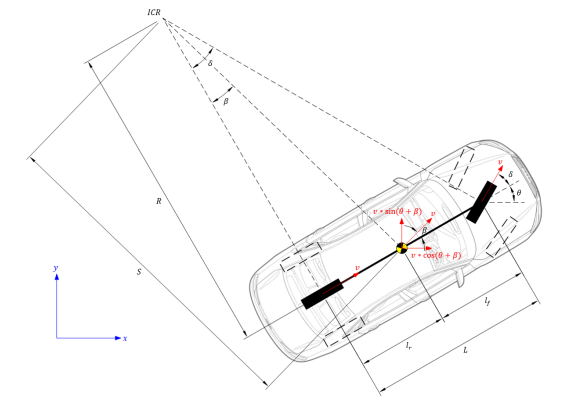

The state variables with respect to t, in terms of Δt - time step size:

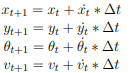

The gradient of the above variables.

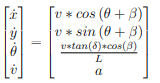

These variables are calculated at the end of the each time step in loop. There is loss function in terms of the control input, based on this function the controller gives the action variables. This loss is calculated at the end of the each time step. The no time steps that has been used are 100. This kind of simulation is run for 50 to train the neural network used as a close loop  controller which has state variables as the input and action variables as the output.

The loss function is written in terms of state variables the and for simplicity purposes the final position is  considered to be (0,0). Since the vehicle has to stop and orientation has to be zero, the final state variables comes down to be zero.The loss function with respect to control parameters:

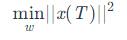

Since the objective function is expressed in terms of the state variables and time. This problem is an unconstrained problem.

In [8]:
import logging
import math
import random
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

logger = logging.getLogger(__name__)

In [9]:
#environment parameters
FRAME_TIME = 0.1  # time interval
BOOST_ACCEL = 1  # thrust constant

The dynamics of the car has been established using pytorch.
The above mentioned equations have been simplified using tensor math.

State tensor(t) represents the current state

delta state represents the gradient of the current state.

T: Time


The below matrix math hase been used to write the dynamics block of the code.

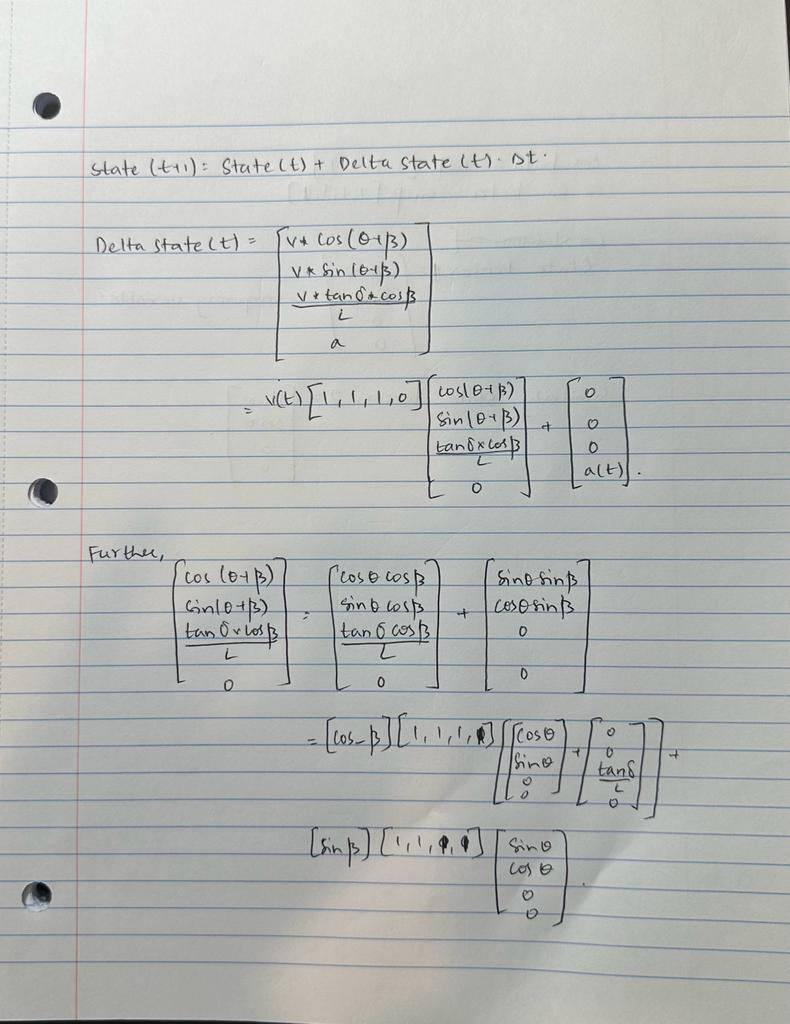

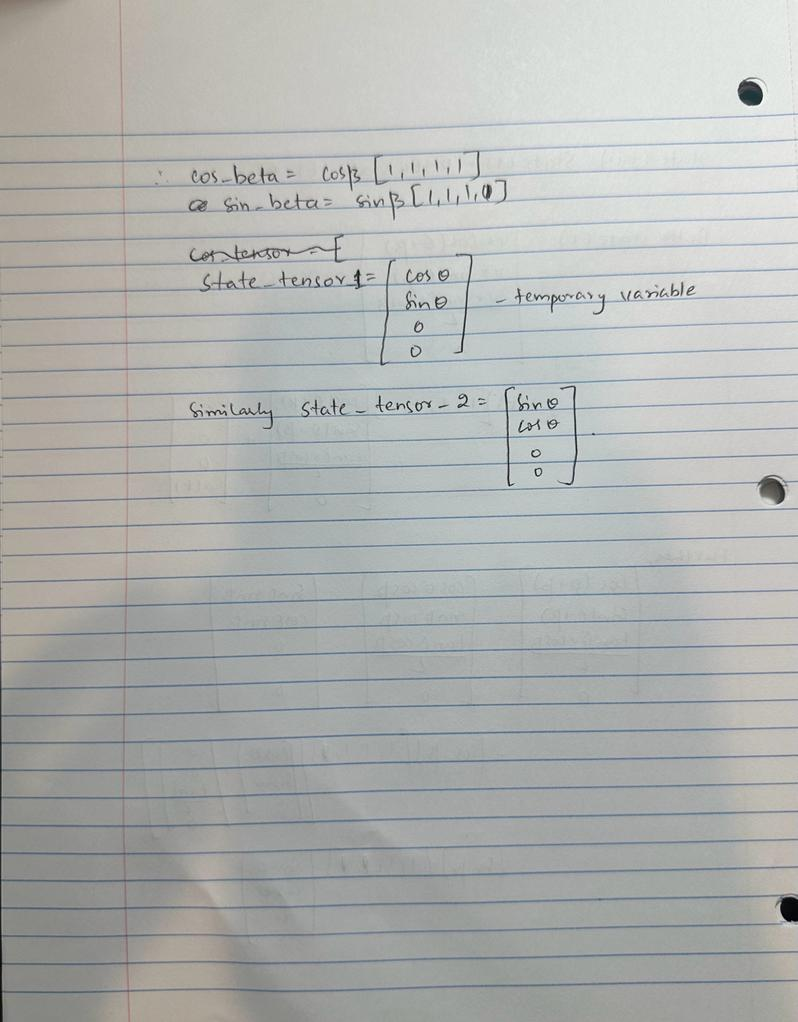

In [10]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = Thrust
        action[1] = delta

        state[0] = x
        state[1] = y
        state[2] = theta
        state[3] = v

        """

        t = torch.tan(action[0,1])
        steering_angle_tan = torch.div(t,2)
        beta = torch.atan(steering_angle_tan)

        state_tensor_1 = torch.zeros((1, 4))
        state_tensor_1[0, 0] = torch.cos(state[0, 3])
        state_tensor_1[0, 1] = torch.sin(state[0, 3])
        state_tensor_1[0, 2] = t

        state_tensor_2 = torch.zeros((1, 4))
        state_tensor_2[0, 0] = torch.sin(state[0, 3])
        state_tensor_2[0, 1] = torch.cos(state[0, 3])
        cos_beta=torch.cos(beta)
        cos_tensor = torch.mul(torch.tensor([1.,1.,1.,0.]),cos_beta.reshape(-1,1))
        sin_beta=torch.sin(beta)
        sin_tensor = torch.mul(torch.tensor([1.,1.,0.,0.]),sin_beta.reshape(-1,1))
        velocity_tensor = torch.mul(torch.tensor([1.,1.,1.,0.]),state[0,2].reshape(-1,1))

        temp = torch.mul(cos_tensor,state_tensor_1) + torch.mul(sin_tensor,state_tensor_2)
        temp2 = torch.mul(velocity_tensor,temp)

        acceleration_tensor = BOOST_ACCEL * torch.mul(torch.tensor([0., 0., 0., 1.]),action[0, 0].reshape(-1, 1))

        delta_state = FRAME_TIME * (temp2 + acceleration_tensor)

        state = state + delta_state

        return state

The state variables calculated above have pushed into the controller in a forward pass where the error is calculted and input into the neural network with 6 hidden inputs and 2 outputs. The neural network uses the tanh and sigmoid functions as the activation functions.

In [11]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden:
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        action = (action - torch.tensor([0.5, 0.5]))*2  # bound theta_dot range -1 to 1
        return action


The above 2 blocks have been calculated for each timestep and they have calculated for an interval of 100 time intervals using the simulation block where the intial state variables as given as (20, 40, 0.5, 0).

In [12]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [[20.,40.,0.5,0]]
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):

        return torch.mean(state ** 2)


The below segment of the code is the optimization block where the simulation is run for 50 times(epoch) to train the neural network. The Limited memory Broyden–Fletcher–Goldfarb–Shanno (LBFGS) algorithm is used as an optimizer. The gradients are calculated using the inbuilt function in optimizer.

Visualisation of the data has also been added to the code to better visualise the results. The state variables and also the action variables for each of the epoch has been plotted to understand the change.

Also the convergence plot for the algorithm has been plotted.

To better visualise the motion of the car the animation of the final iteration has been done using the funcanimation module of the matplotlib.

In [13]:
class Optimize:

    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects

    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # define the opmization algorithm
        self.loss_list = []

    # Define loss calculation method for objective function

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model


    def train(self, epochs):
        # self.optimizer = epoch
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            #print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            self.visualize()

        plt.plot(list(range(epochs)), l)

        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        self.animation(epochs)

    # Define result visualization method

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        v = data[:, 3]
        theta = data[:, 2]

        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        thrust = action_data[:,0]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(1, 4, tight_layout = 1, figsize = (15, 5))

        ax[0].plot(x, y, c = 'b')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Y")
        ax[0].set(title=f'Displacement plot(x-y) at frame {self.epoch}')

        ax[1].plot(frame, v, c = 'c', label = "Velocity")
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Velocity (m/s)")
        ax[1].legend(frameon=0)
        ax[1].set(title =f'Velocity plot at frame {self.epoch}')

        ax[2].plot(frame, theta, c = 'g', label = "theta")
        ax[2].set_xlabel("Time interval")
        ax[2].set_ylabel("Theta")
        ax[2].legend(frameon=0)
        ax[2].set(title=f'Theta plot at {self.epoch}')

        ax[3].plot(frame, thrust, c = 'y', label = "thrust")
        ax[3].set_xlabel("Time interval")
        ax[3].set_ylabel("Thrust")
        ax[3].legend(frameon=0)
        ax[3].set(title=f'Thrust plot at {self.epoch}')
        plt.show()

    def animation(self, epochs):
              # Size
        length = 0.10          # m
        width = 0.02          # m

        #
        v_exhaust = 1
        print("Generating Animation")
        steps = self.simulation.T + 1
        final_time_step = round(1/steps,2)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])

        x_t = data
        u_t = action_data

        fig = plt.figure(figsize = (5,8), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        plt.axhline(y=0., color='b', linestyle='--', lw=0.8)

        car, = ax1.plot([], [], linewidth = 10, color = 'lightblue') # car body
        path, = ax1.plot([], [], '--', linewidth = 2, color = 'orange') # path line
        # ln2, = ax1.plot([], [], linewidth = 4, color = 'tomato') # thrust line

        plt.tight_layout()

        ax1.set_xlim(-50, 50)
        ax1.set_ylim(-20, 50)
        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

        def update(i):
            car_theta = x_t[i, 2]

            car_x = x_t[i, 0]
            # length/1 is just to make rocket bigger in animation
            car_x_points = [car_x + length/1 * np.sin(car_theta), car_x - length/1 * np.sin(car_theta)]

            car_y = x_t[i, 1]
            car_y_points = [car_y + length/1 * np.cos(car_theta), car_y - length/1 * np.cos(car_theta)]

            car.set_data(car_x_points, car_y_points)

            thrust_mag = u_t[i, 0]
            thrust_angle = -u_t[i, 1]

            # flame_length = (thrust_mag) * (0.4/v_exhaust)
            # # flame_x_points = [rocket_x_points[1], rocket_x_points[1] + flame_length * np.sin(thrust_angle - rocket_theta)]
            # # flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(thrust_angle - rocket_theta)]
            # flame_x_points = [rocket_x_points[1], rocket_x_points[1] - flame_length * np.sin(rocket_theta)]
            # flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(rocket_theta)]

            # ln2.set_data(flame_x_points, flame_y_points)
            path.set_data(x_t[:i, 0], x_t[:i, 1])
            f.value += 1

        playback_speed = 5000 # the higher the slower
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save as GIF
        writer = PillowWriter(fps=20)
        anim.save("car.gif", writer=writer)

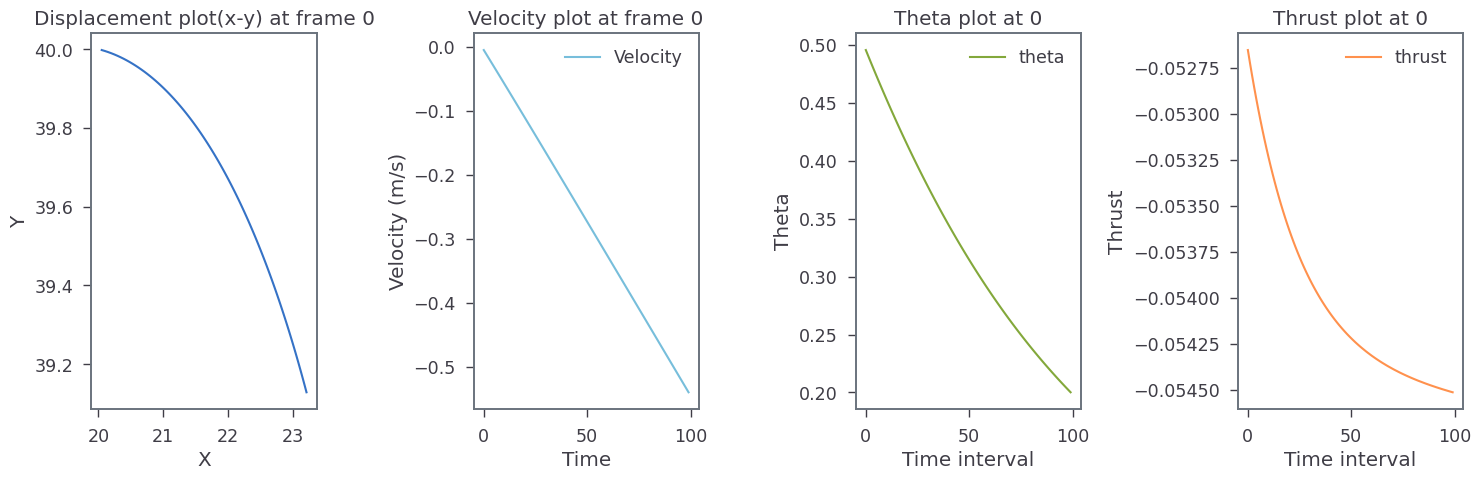

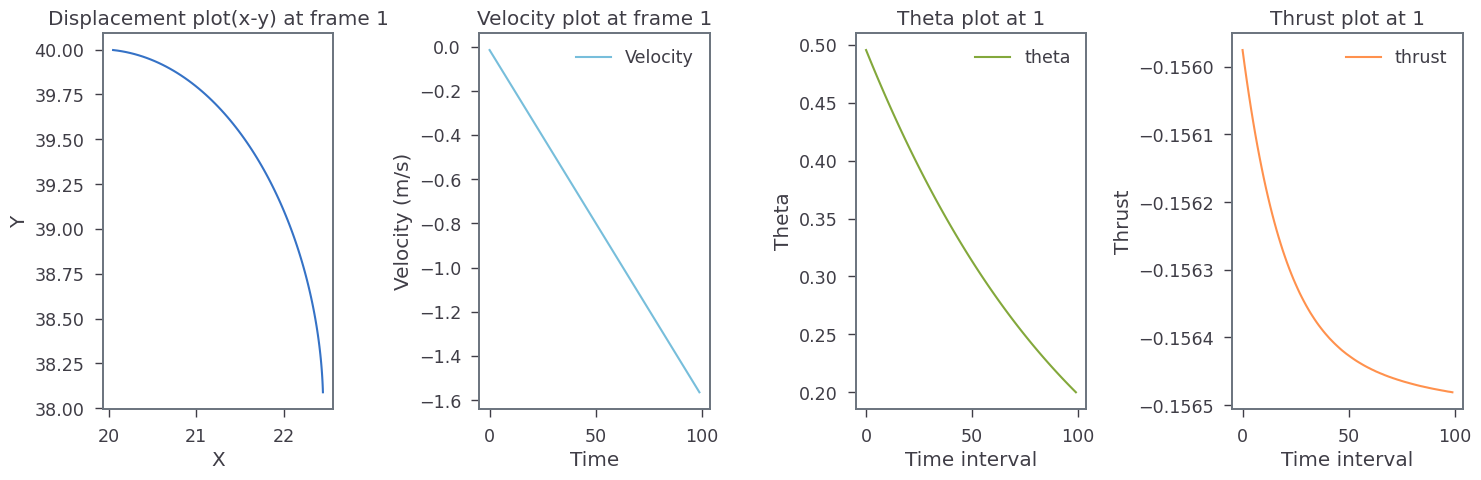

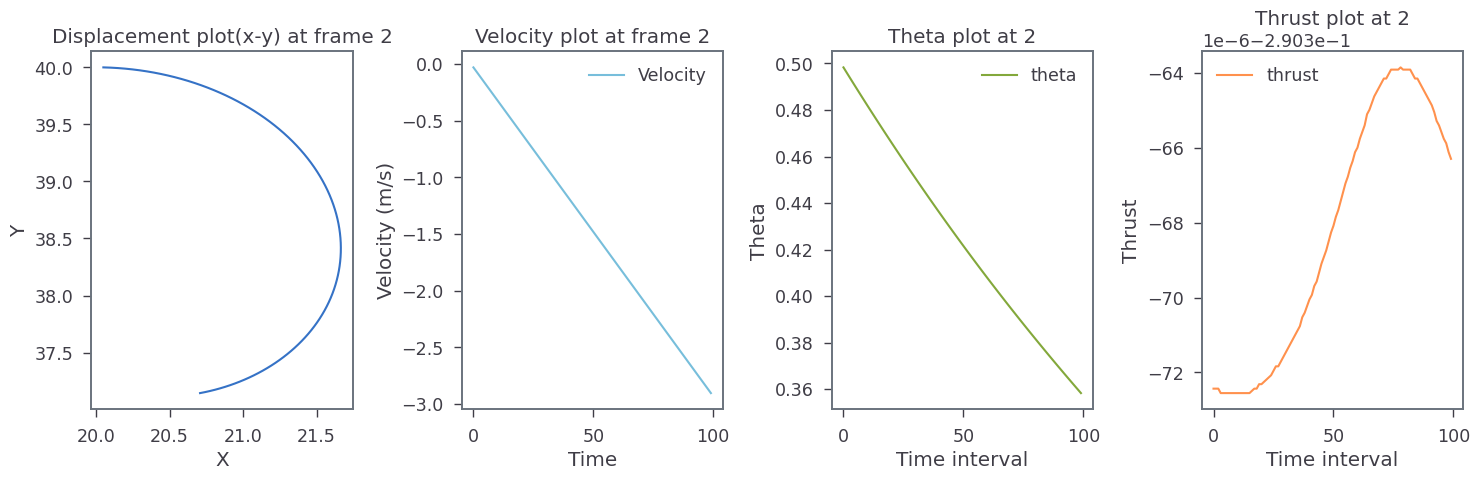

In [ ]:
T = 100  # number of time steps of the simulation
dim_input = 4  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()
c = Controller(dim_input, dim_hidden, dim_output)
s = Simulation(c, d, T)
o = Optimize(s)
o.train(50)  # training with number of epochs (gradient descent steps)